In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import polars as pl
import plotly.graph_objects as go


/home/jeremy/.cache/pypoetry/virtualenvs/comparison-embeddings-JDigj-vw-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bert_model_name = 'google-bert/bert-base-uncased'
num_classes = 6
max_length = 512
batch_size = 8
num_epochs = 10
learning_rate = 2e-5

In [3]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [4]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            x = self.dropout(pooled_output)
            logits = self.fc(x)
            return logits

In [5]:
from tqdm import tqdm

def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training", unit="batch"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    
    return total_loss / len(data_loader)

In [6]:
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            
            # Accumulate loss
            total_loss += loss.item()

            # Collect predictions and labels for metrics
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    
    # Calculate accuracy and classification report
    accuracy = accuracy_score(actual_labels, predictions)
    report = classification_report(actual_labels, predictions)

    # Return average validation loss, accuracy, and classification report
    return total_loss / len(data_loader), accuracy, report

In [7]:
def predict(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Collect predictions and labels for metrics
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    
    return predictions, actual_labels

In [8]:
df = pl.read_parquet("amazon.parquet")


In [9]:
x = df.select("review_text").to_series().to_list()
y = df.select("rating_score").to_series().to_list()

In [10]:
x

["I registered on the website, tried to order a laptop, entered all the details, but instead of charging me and sending the product, they froze my account, demanding various verification documents. I sent them over. They said they would review them within 24 hours. In reality, it's been a week, and no one can help or give any (truthful) estimate of when it will be resolved; they just tell me to 'wait.' I've never seen such a horrible marketplace in my life. I hope those who came up with this can't buy food in a store, receiving a 'document review request' that takes forever to process.",
 "Had multiple orders one turned up and driver had to phone as no door number on packaging, then waited all day for second package to get a message saying couldn't deliver as no number on packaging, 12 hours waiting in now don't even know when I'm getting delivery. Terrible will never use again",
 'I informed these reprobates that I WOULD NOT BE IN as I was going to visit a sick relative, they told me 

In [11]:
train_text, test_text, train_label, test_label = train_test_split(x, y, test_size=0.2, random_state=42)
test_text, val_text, test_label, val_label = train_test_split(test_text, test_label, test_size=0.5, random_state=42)

In [12]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = TextClassificationDataset(train_text, train_label, tokenizer, max_length)
test_dataset = TextClassificationDataset(test_text, test_label, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_text, val_label, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [14]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/home/jeremy/.cache/pypoetry/virtualenvs/comparison-embeddings-JDigj-vw-py3.12/lib/python3.12/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss = train(model, train_dataloader, optimizer, scheduler, device)
        val_loss, accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Val loss: {val_loss:.4f}")
        print(report)
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        val_acc_hist.append(accuracy)

Epoch 1/10


Training: 100%|██████████| 2106/2106 [34:04<00:00,  1.03batch/s]


Validation Accuracy: 0.8381
Train loss: 0.6033
Val loss: 0.4940
              precision    recall  f1-score   support

           1       0.89      0.97      0.93      1346
           2       0.50      0.01      0.02       123
           3       0.48      0.16      0.24        76
           4       0.55      0.24      0.33       123
           5       0.74      0.96      0.84       438

    accuracy                           0.84      2106
   macro avg       0.63      0.47      0.47      2106
weighted avg       0.80      0.84      0.80      2106

Epoch 2/10


Training: 100%|██████████| 2106/2106 [29:36<00:00,  1.19batch/s]
/home/jeremy/.cache/pypoetry/virtualenvs/comparison-embeddings-JDigj-vw-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeremy/.cache/pypoetry/virtualenvs/comparison-embeddings-JDigj-vw-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jeremy/.cache/pypoetry/virtualenvs/comparison-embeddings-JDigj-vw-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

Validation Accuracy: 0.8333
Train loss: 0.4614
Val loss: 0.5087
              precision    recall  f1-score   support

           1       0.89      0.97      0.93      1346
           2       0.00      0.00      0.00       123
           3       0.34      0.39      0.37        76
           4       0.46      0.21      0.29       123
           5       0.80      0.89      0.84       438

    accuracy                           0.83      2106
   macro avg       0.50      0.49      0.49      2106
weighted avg       0.77      0.83      0.80      2106

Epoch 3/10


Training:  93%|█████████▎| 1959/2106 [26:59<02:01,  1.21batch/s]


KeyboardInterrupt: 

In [ ]:
if False:
    train_epochs = list(range(len(train_loss_hist)))
    
    import plotly.graph_objects as go
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_epochs, y=train_loss_hist,
                        mode='lines+markers',
                        name='training_loss'))
    fig.add_trace(go.Scatter(x=train_epochs, y=val_loss_hist,
                        mode='lines+markers',
                        name='validation_loss'))
    
    fig.update_layout(
            title=dict(
                text='Party classifier with BERT'
            ),
            xaxis=dict(
                title=dict(
                    text='epoch'
                )
            ),
            yaxis=dict(
                title=dict(
                    text='loss'
                )
            ),
    )
    
    fig.write_html("party_classifier_training.html")
    
    fig.show()

In [ ]:
y_pred, y_test = predict(model, test_dataloader, device)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize="true")

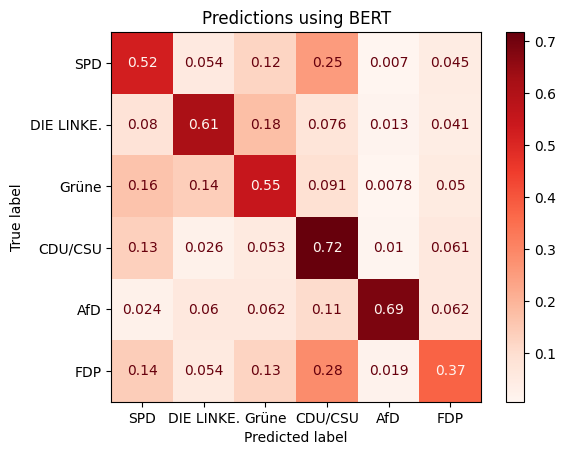

In [ ]:
import matplotlib.pyplot as plt
fig = ConfusionMatrixDisplay(cm, display_labels=label_to_num)
fig.plot(cmap='Reds')
fig.ax_.set_title("Predictions using BERT") 
plt.savefig('cm_bert.png')

In [ ]:
import random
def random_predictor(amount):
    preds = []
    for i in range(amount):
        randint = random.randint(0, 5)
        preds.append(randint)
    return preds

In [ ]:
y_pred_random = random_predictor(len(y_test))

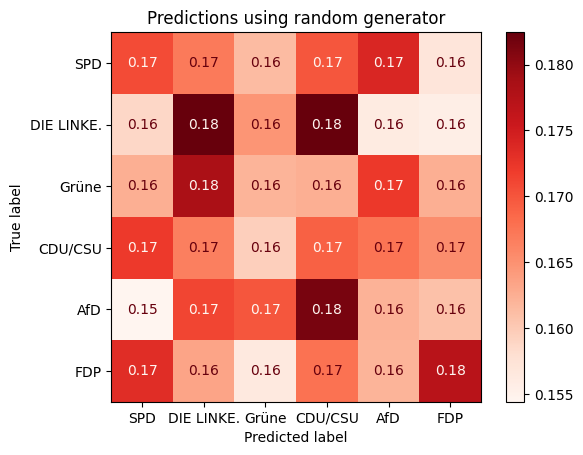

In [ ]:
cm = confusion_matrix(y_test, y_pred_random, normalize="true")
fig = ConfusionMatrixDisplay(cm, display_labels=label_to_num)
fig.plot(cmap='Reds')
fig.ax_.set_title("Predictions using random generator") 
plt.savefig('cm_random.png')

In [ ]:
torch.save(model, "2005_party_model.pth")

In [ ]:
import shap
from transformers import pipeline

pipe = pipeline('text-classification', model=model, tokenizer=tokenizer, device='cpu')
explainer = shap.Explainer(pipe)
shap_values = explainer(val_texts[15:17])